Задание: реализовать простейшую сеть Хопфилда и протестировать на зашумлённых изображениях
Изучение темы: http://neupy.com/2015/09/20/discrete_hopfield_network.html
Решение: 
1. создать шаблоны букв 10*10
2. настроить веса а сети и написать функции обработки изображений
3. получить зашумлённые изображения
4. получить на них результаты работы синхронной и асинхронной работы сети
5. сравнить результаты


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
letter_a = ['0000110000',
            '0001111000',
            '0011111100',
            '0111001110',
            '1110000111',
            '1100000011',
            '1111111111',
            '1111111111',
            '1100000011',
            '1100000011']
letter_t = ['1111111111',
            '1111111111',
            '0000110000',
            '0000110000',
            '0000110000',
            '0000110000',
            '0000110000',
            '0000110000',
            '0000110000',
            '0000110000']
letter_k = ['1100011000',
            '1100110000',
            '1101100000',
            '1111000000',
            '1110000000',
            '1111000000',
            '1101100000',
            '1100110000',
            '1100011000',
            '1100001100']
letters_templates = [letter_a, letter_t, letter_k]

In [42]:
letters = []
for l in letters_templates:
    l_list = []
    for str_l in l:
        str_list = list(map(int, list(str_l)))
        str_list = [-1 if lx == 0 else 1 for lx in str_list]
        l_list += str_list
    letters += [l_list]

letters = np.array(letters)
print(letters.shape)

(3, 100)


In [189]:
class Network:
    def __init__(self, templates, n_cycles):
        self.n_cycles = n_cycles
        self.templates = templates
        self.n_templates = templates.shape[0]
        self.n_neurons = templates.shape[1]
        self.W = np.zeros((self.n_neurons, self.n_neurons))
        
        for template in templates:
            self.W += np.outer(template, template)
        np.fill_diagonal(self.W, 0)
        self.W = self.W / self.n_templates
        
    def energy(self, image):
        return -0.5 * image.T.dot(self.W.dot(image))
    
    def compare(self, image):
        for i, temp in enumerate(self.templates):
            if np.array_equal(temp, image):
                return i
        return -1
    
    def synchronous_predict(self, images):
        images_new = []
        predictions = []
        for image in images:
            e = self.energy(image)
            s = image
            for i in range(self.n_cycles):
                s = self.W.dot(s)
                s = np.array([-1 if lx < 0 else 1 for lx in s])
                e_new = self.energy(s)
                if e == e_new:
                    images_new += [s]
                    predictions += [self.compare(s)]
                    break
                e = e_new
            if i == self.n_cycles-1:
                images_new += [s]
                predictions += [-1]
        return np.array(images_new), np.array(predictions)
                
            
    def asynchronous_predict(self, images): 
        images_new = []
        predictions = []
        for image in images:
            e = self.energy(image)
            s = image
            for i in range(self.n_cycles):
                for j in range(400):
                    idx = np.random.randint(0, self.n_neurons)
                    s[idx] = -1 if self.W[idx].T.dot(s) < 0 else 1
                e_new = self.energy(s)
                if e == e_new:
                    images_new += [s]
                    predictions += [self.compare(s)]
                    break
                e = e_new
            if i == self.n_cycles-1:
                images_new += [s]
                predictions += [-1]
        return np.array(images_new), np.array(predictions)

In [183]:
def plot_images(images, width = 10):
    shape = int(np.sqrt(images.shape[1]))
    fig, ax1 = plt.subplots(len(images)//width, width, figsize=(2, 2), sharex = True, sharey = True)
    if len(images)//width > 1:
        for num, im in enumerate(images):
            ax1[num//width, num%width].imshow(im.reshape((shape, shape)), cmap = 'gray')
    else:
        for num, im in enumerate(images):
            ax1[num%width].imshow(im.reshape((shape, shape)), cmap = 'gray')
    
    plt.show()


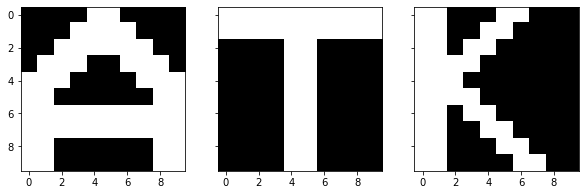

In [134]:
plot_images(letters, 3)

In [139]:
def make_noise(images, noise_percent):
    size = images.shape[1]
    a = np.arange(size)
    images_new = []
    for image in images:
        np.random.shuffle(a)
        randoms = a[:size*noise_percent//100]
        image = np.array([-i if pos in randoms else i for pos, i in enumerate(image)])
        images_new += [image]
    return np.array(images_new)

In [202]:
test_size = 10
net = Network(letters, 5)
noise_percent = np.linspace(0, 100, num=21, dtype = int)
test_letters = np.repeat(letters, test_size, axis=0)
test_answers = np.repeat([0, 1, 2], 10)
s_accuracy = []
a_accuracy = []
for noise in noise_percent:
    noise_test_letters = make_noise(test_letters, noise)
    predicted_images, predictions = net.synchronous_predict(noise_test_letters)
    s_accuracy += [(test_answers == predictions).sum()/(test_size*letters.shape[0])]
    predicted_images, predictions = net.asynchronous_predict(noise_test_letters)
    a_accuracy += [(test_answers == predictions).sum()/(test_size*letters.shape[0])]   


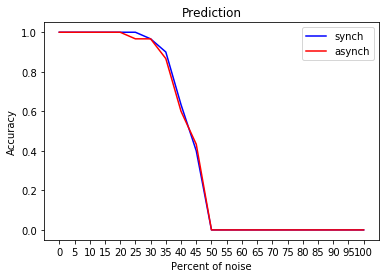

In [203]:
plt.plot(noise_percent, s_accuracy, c = 'b', label = 'synch')
plt.plot(noise_percent, a_accuracy, c = 'r', label = 'asynch')
plt.title('Prediction')
plt.xlabel('Percent of noise')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.xticks(noise_percent)
plt.show()